# Homework 2 Coding Assignment

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)
# ====================================================================
# DATASET 1: RETAIL SALES (for Regression & ETS)
# ====================================================================
print("\n" + "=" * 70)
print("DATASET 1: Monthly Retail Sales")
print("=" * 70)

# Create 4 years of monthly data
dates = pd.date_range('2021-01-01', '2024-12-31', freq='MS')
n_months = len(dates)
t = np.arange(n_months)

# Components
trend = 1000 + 15*t  # Growing business
yearly_seasonal = 300 * np.sin(2*np.pi*t/12) + 200 * np.cos(2*np.pi*t/12)

# Holiday effects (November-December spike)
holiday_effect = np.zeros(n_months)
for year in range(4):
    nov_idx = year*12 + 10  # November
    dec_idx = year*12 + 11  # December
    if nov_idx < n_months:
        holiday_effect[nov_idx] = 400
    if dec_idx < n_months:
        holiday_effect[dec_idx] = 600

# Random noise
noise = np.random.normal(0, 80, n_months)

# Combine
sales = trend + yearly_seasonal + holiday_effect + noise
sales = np.maximum(sales, 0)

# Create DataFrame
df_sales = pd.DataFrame({
    'Date': dates,
    'Sales': sales,
    'Month': dates.month,
    'Year': dates.year,
    'Time': t
})
df_sales.set_index('Date', inplace=True)

print(f"Date range: {df_sales.index[0].date()} to {df_sales.index[-1].date()}")
print(f"Number of months: {len(df_sales)}")
print(f"\nSales Statistics:")
print(df_sales['Sales'].describe())



DATASET 1: Monthly Retail Sales
Date range: 2021-01-01 to 2024-12-01
Number of months: 48

Sales Statistics:
count      48.000000
mean     1419.409544
std       352.878551
min       722.634428
25%      1196.284168
50%      1393.908200
75%      1710.667034
max      2412.774859
Name: Sales, dtype: float64



PART A: REGRESSION AND ETS MODELS

----------------------------------------------------------------------
A1: Exploratory Visualization
----------------------------------------------------------------------


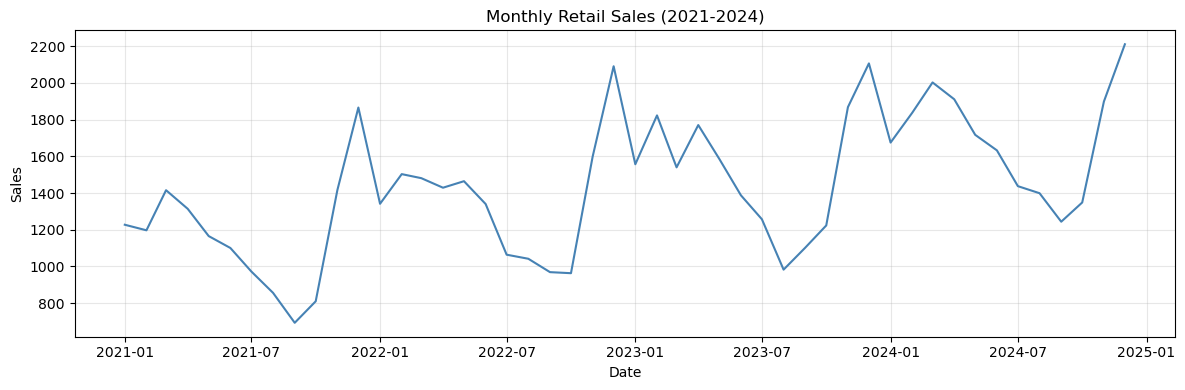

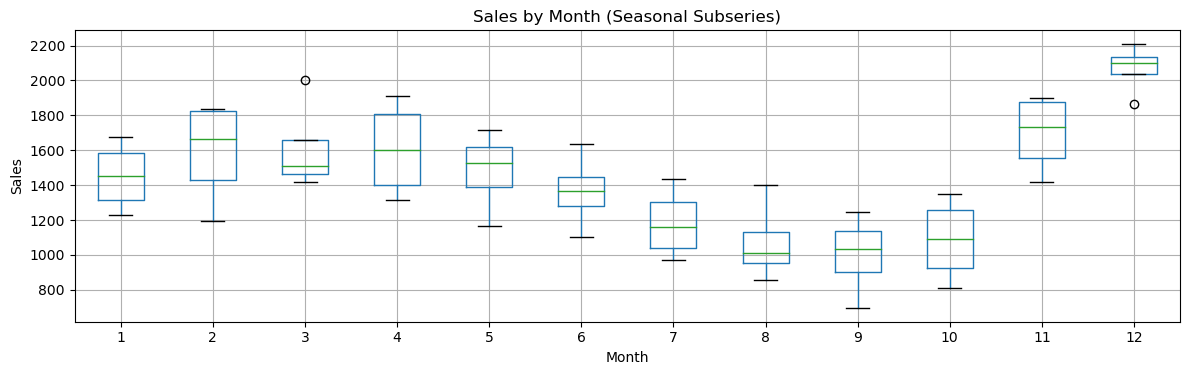

Months with highest average sales:
Month
12    2068.841011
11    1695.761277
3     1610.075741
4     1606.387294
2     1590.488830
Name: Sales, dtype: float64


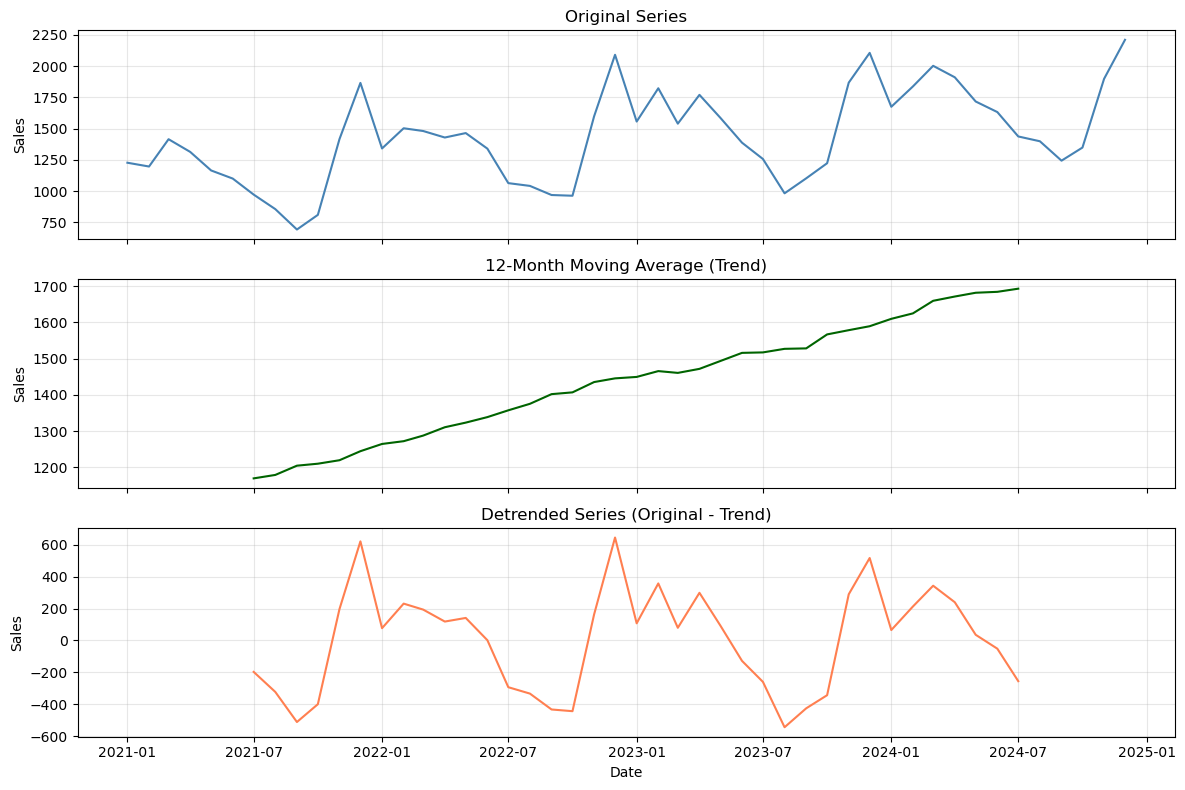

In [10]:
# ====================================================================
# PART A: REGRESSION AND ETS MODELS
# ====================================================================
print("\n" + "=" * 70)
print("PART A: REGRESSION AND ETS MODELS")
print("=" * 70)

# --------------------------------------------------------------------
# A1: Time Series Visualization
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("A1: Exploratory Visualization")
print("-" * 70)

# 1. Time series plot of monthly sales
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df_sales.index, df_sales['Sales'], color='steelblue')
ax.set_title('Monthly Retail Sales (2021-2024)')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Seasonal subseries plot: Box plot of sales by month
fig, ax = plt.subplots(figsize=(12, 4))
df_sales.boxplot(column='Sales', by='Month', ax=ax)
ax.set_title('Sales by Month (Seasonal Subseries)')
ax.set_xlabel('Month')
ax.set_ylabel('Sales')
plt.suptitle('')
plt.tight_layout()
plt.show()

# Which months have highest sales?
monthly_means = df_sales.groupby('Month')['Sales'].mean()
print("Months with highest average sales:")
print(monthly_means.sort_values(ascending=False).head())

# 3. Decomposition plot: Original, 12-month MA (trend), Detrended
trend_12m = df_sales['Sales'].rolling(window=12, center=True).mean()
detrended = df_sales['Sales'] - trend_12m

fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
axes[0].plot(df_sales.index, df_sales['Sales'], color='steelblue')
axes[0].set_ylabel('Sales')
axes[0].set_title('Original Series')
axes[0].grid(True, alpha=0.3)

axes[1].plot(df_sales.index, trend_12m, color='darkgreen')
axes[1].set_ylabel('Sales')
axes[1].set_title('12-Month Moving Average (Trend)')
axes[1].grid(True, alpha=0.3)

axes[2].plot(df_sales.index, detrended, color='coral')
axes[2].set_ylabel('Sales')
axes[2].set_xlabel('Date')
axes[2].set_title('Detrended Series (Original - Trend)')
axes[2].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



In [ ]:
# --------------------------------------------------------------------
# A2: Regression Model (Trend + Seasonal)
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("A2: Regression Model")
print("-" * 70)

# Add seasonal dummies (month 1-11; December is reference)
df_reg = df_sales.copy()
for m in range(1, 12):
    df_reg[f'Month_{m}'] = (df_reg['Month'] == m).astype(int)

X = df_reg[['Time'] + [f'Month_{m}' for m in range(1, 12)]]
X = sm.add_constant(X)
y = df_reg['Sales']

model_reg = sm.OLS(y, X).fit()
print(model_reg.summary())
print(f"\nR-squared: {model_reg.rsquared:.4f}")



----------------------------------------------------------------------
A2: Regression Model
----------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     79.67
Date:                Fri, 13 Feb 2026   Prob (F-statistic):           9.79e-22
Time:                        17:56:06   Log-Likelihood:                -270.65
No. Observations:                  48   AIC:                             567.3
Df Residuals:                      35   BIC:                             591.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t   


----------------------------------------------------------------------
A3: ETS Model (Holt-Winters)
----------------------------------------------------------------------
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   48
Model:             ExponentialSmoothing   SSE                         276629.745
Optimized:                         True   AIC                            447.643
Trend:                         Additive   BIC                            477.582
Seasonal:                      Additive   AICC                           471.229
Seasonal Periods:                    12   Date:                 Fri, 13 Feb 2026
Box-Cox:                          False   Time:                         17:56:29
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
-----------------

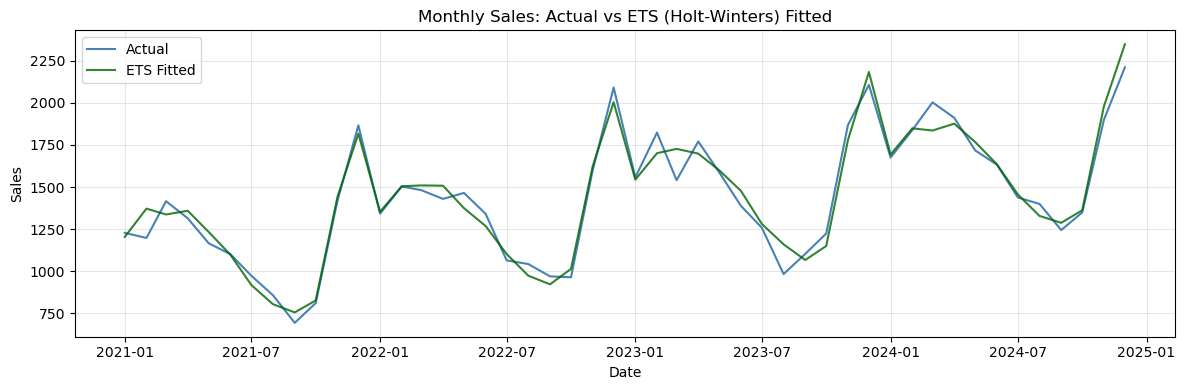

In [ ]:

# --------------------------------------------------------------------
# A3: ETS Model (Holt-Winters Exponential Smoothing)
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("A3: ETS Model (Holt-Winters)")
print("-" * 70)

# Fit Holt-Winters with additive trend and seasonal
ets_model = ExponentialSmoothing(
    df_sales['Sales'],
    seasonal_periods=12,
    trend='add',
    seasonal='add'
).fit()

print(ets_model.summary())
print(f"\nETS AIC: {ets_model.aic:.2f}")

# Plot: Actual vs ETS fitted
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df_sales.index, df_sales['Sales'], label='Actual', color='steelblue')
ax.plot(df_sales.index, ets_model.fittedvalues, label='ETS Fitted', color='darkgreen', alpha=0.8)
ax.set_title('Monthly Sales: Actual vs ETS (Holt-Winters) Fitted')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



----------------------------------------------------------------------
A4: Simple Exponential Smoothing
----------------------------------------------------------------------
Optimized α (smoothing level): 0.3952
Interpretation: α controls how much weight is given to recent observations.
  - α = 0.40 means moderate responsiveness to recent changes.
  - Lower α = smoother series, more weight on history.
  - Higher α = more reactive to recent values.

Forecast accuracy on holdout period (last 12 months):
  MAE:  191.69
  RMSE: 208.02
  MAPE: 11.76%


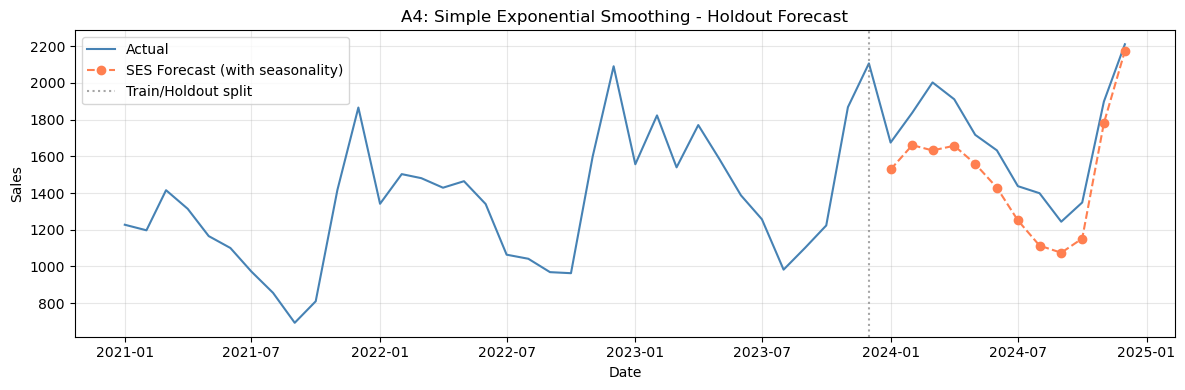

In [14]:
# --------------------------------------------------------------------
# A4: Simple Exponential Smoothing (SES)
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("A4: Simple Exponential Smoothing")
print("-" * 70)

# Use only first 36 months for training; last 12 months for holdout
train_size = 36
holdout_size = 12
train_data = df_sales['Sales'].iloc[:train_size]
train_index = df_sales.index[:train_size]

# 1. Deseasonalize sales using seasonal averages
seasonal_component = train_data.groupby(train_index.month).mean()
seasonal_vals_train = seasonal_component.reindex(train_index.month).values
deseasonalized = train_data.values - seasonal_vals_train + train_data.mean()
deseasonalized = pd.Series(deseasonalized, index=train_index)

# 2. Fit SES on deseasonalized data (optimize α)
ses_model = SimpleExpSmoothing(deseasonalized).fit(optimized=True)

# 3. Print optimized α and interpretation
alpha = ses_model.params['smoothing_level']
print(f"Optimized α (smoothing level): {alpha:.4f}")
print("Interpretation: α controls how much weight is given to recent observations.")
print(f"  - α = {alpha:.2f} means moderate responsiveness to recent changes.")
print("  - Lower α = smoother series, more weight on history.")
print("  - Higher α = more reactive to recent values.")

# 4. Generate SES forecasts for next 12 months (deseasonalized)
ses_forecast_deseason = ses_model.forecast(steps=holdout_size)

# 5. Add seasonality back to forecasts (Jan=1 through Dec=12)
future_months = np.arange(1, 13)
seasonal_vals = seasonal_component.reindex(future_months).fillna(seasonal_component.mean())
ses_forecast = ses_forecast_deseason.values + seasonal_vals.values - deseasonalized.mean()

# 6. Calculate forecast accuracy on holdout period
holdout_actual = df_sales['Sales'].iloc[train_size:train_size + holdout_size].values
mae = np.mean(np.abs(ses_forecast - holdout_actual))
rmse = np.sqrt(np.mean((ses_forecast - holdout_actual) ** 2))
mape = np.mean(np.abs((ses_forecast - holdout_actual) / holdout_actual)) * 100

print(f"\nForecast accuracy on holdout period (last {holdout_size} months):")
print(f"  MAE:  {mae:.2f}")
print(f"  RMSE: {rmse:.2f}")
print(f"  MAPE: {mape:.2f}%")

# Plot: Actual vs SES forecast on holdout
fig, ax = plt.subplots(figsize=(12, 4))
holdout_dates = df_sales.index[train_size:train_size + holdout_size]
ax.plot(df_sales.index, df_sales['Sales'], label='Actual', color='steelblue')
ax.plot(holdout_dates, ses_forecast, label='SES Forecast (with seasonality)', color='coral', linestyle='--', marker='o')
ax.axvline(df_sales.index[train_size - 1], color='gray', linestyle=':', alpha=0.7, label='Train/Holdout split')
ax.set_title('A4: Simple Exponential Smoothing - Holdout Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


----------------------------------------------------------------------
A5: Holt's Method
----------------------------------------------------------------------
Optimized α (level smoothing): 0.1243
Optimized β (trend smoothing): 0.0028

Final state:
  Level (ℓₜ): 1561.3536
  Trend (bₜ): 12.6940


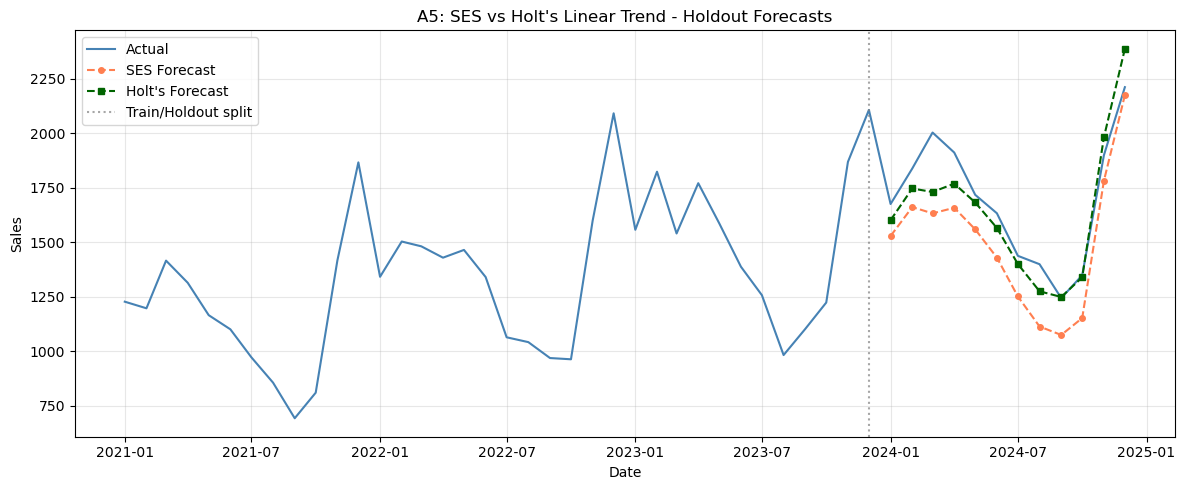


Which captures the trend better?
Holt's method captures the trend better because it explicitly models the trend component (β).
SES assumes a constant level, so forecasts flatten. Holt's forecasts follow the upward trend.


In [15]:
# --------------------------------------------------------------------
# A5: Holt's Linear Trend Method
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("A5: Holt's Method")
print("-" * 70)

# 1. Fit Holt's linear trend on deseasonalized data (from A4)
holt_model = Holt(deseasonalized).fit(optimized=True)

# 2. Print optimized parameters
alpha_holt = holt_model.params['smoothing_level']
beta_holt = holt_model.params['smoothing_trend']
print(f"Optimized α (level smoothing): {alpha_holt:.4f}")
print(f"Optimized β (trend smoothing): {beta_holt:.4f}")

# 3. Extract final state (level ℓₜ and trend bₜ)
level = float(holt_model.level.iloc[-1])
trend = float(holt_model.trend.iloc[-1])
print(f"\nFinal state:")
print(f"  Level (ℓₜ): {level:.4f}")
print(f"  Trend (bₜ): {trend:.4f}")

# 4. Generate 12-month forecasts (deseasonalized) and add seasonality back
holt_forecast_deseason = holt_model.forecast(steps=holdout_size)
future_months = np.arange(1, 13)
seasonal_vals = seasonal_component.reindex(future_months).fillna(seasonal_component.mean())
holt_forecast = np.asarray(holt_forecast_deseason) + seasonal_vals.values - deseasonalized.mean()

# 5. Compare with SES: plot both forecast paths
fig, ax = plt.subplots(figsize=(12, 5))
holdout_dates = df_sales.index[train_size:train_size + holdout_size]
ax.plot(df_sales.index, df_sales['Sales'], label='Actual', color='steelblue')
ax.plot(holdout_dates, ses_forecast, label='SES Forecast', color='coral', linestyle='--', marker='o', markersize=4)
ax.plot(holdout_dates, holt_forecast, label="Holt's Forecast", color='darkgreen', linestyle='--', marker='s', markersize=4)
ax.axvline(df_sales.index[train_size - 1], color='gray', linestyle=':', alpha=0.7, label='Train/Holdout split')
ax.set_title("A5: SES vs Holt's Linear Trend - Holdout Forecasts")
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nWhich captures the trend better?")
print("Holt's method captures the trend better because it explicitly models the trend component (β).")
print("SES assumes a constant level, so forecasts flatten. Holt's forecasts follow the upward trend.")


----------------------------------------------------------------------
A6: Holt-Winters Method
----------------------------------------------------------------------
Optimized α (level): 0.1072
Optimized β (trend): 0.0322
Optimized γ (seasonal): 0.0033

Final state:
  Level (ℓₜ): 1604.2700
  Trend (bₜ): 14.3974
  Seasonal indices (last 12):
Date
2023-01-01     87.565790
2023-02-01    228.293209
2023-03-01    157.048935
2023-04-01    184.360431
2023-05-01     77.339348
2023-06-01    -73.180628
2023-07-01   -262.593143
2023-08-01   -398.320154
2023-09-01   -470.175212
2023-10-01   -410.974795
2023-11-01    201.706836
2023-12-01    600.423133
dtype: float64


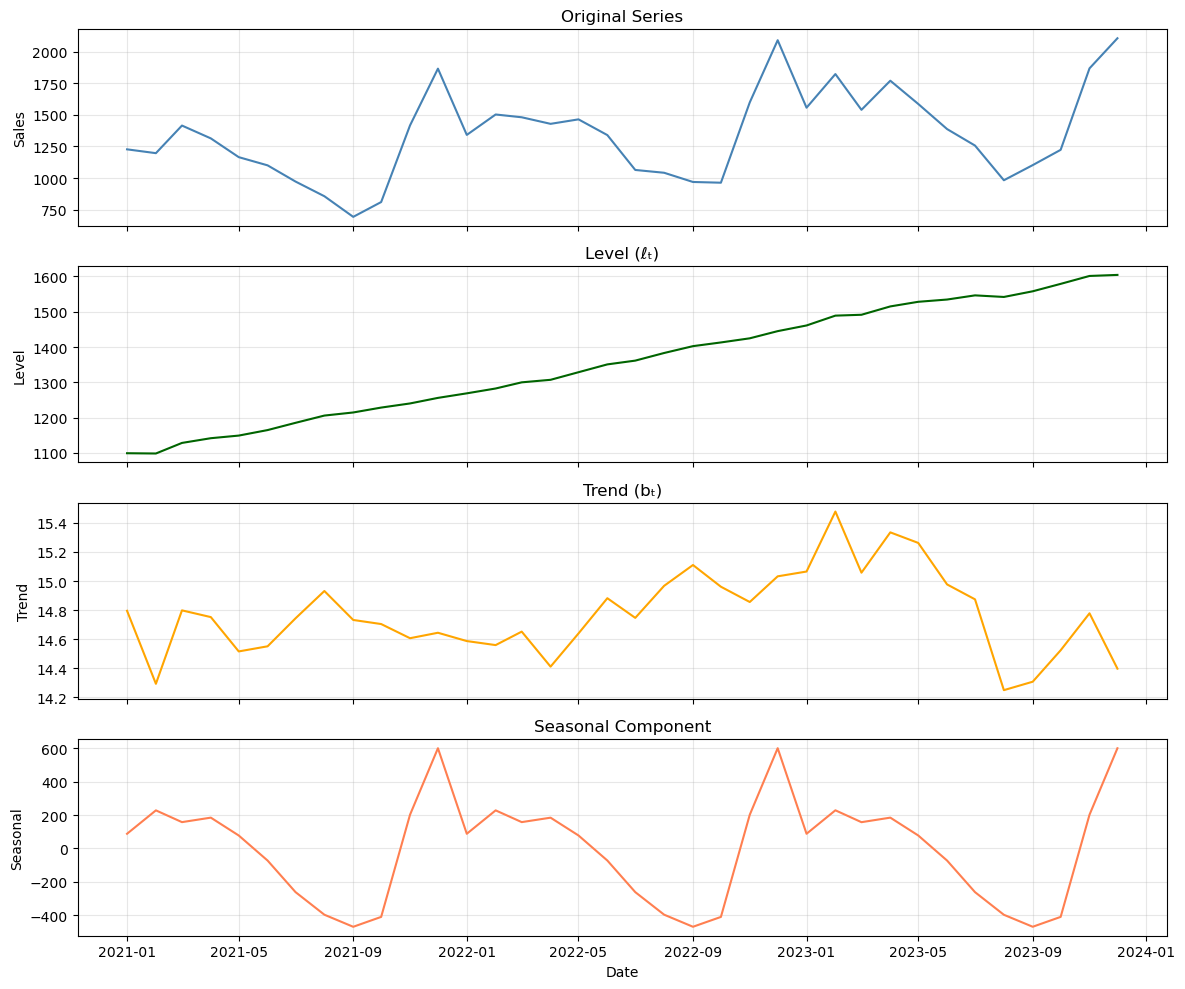


Forecast accuracy comparison (holdout period):
       Model        MAE       RMSE
  Regression  43.966740  60.594792
         SES 191.691539 208.019353
      Holt's  93.107103 118.626326
Holt-Winters  59.633397  84.371671


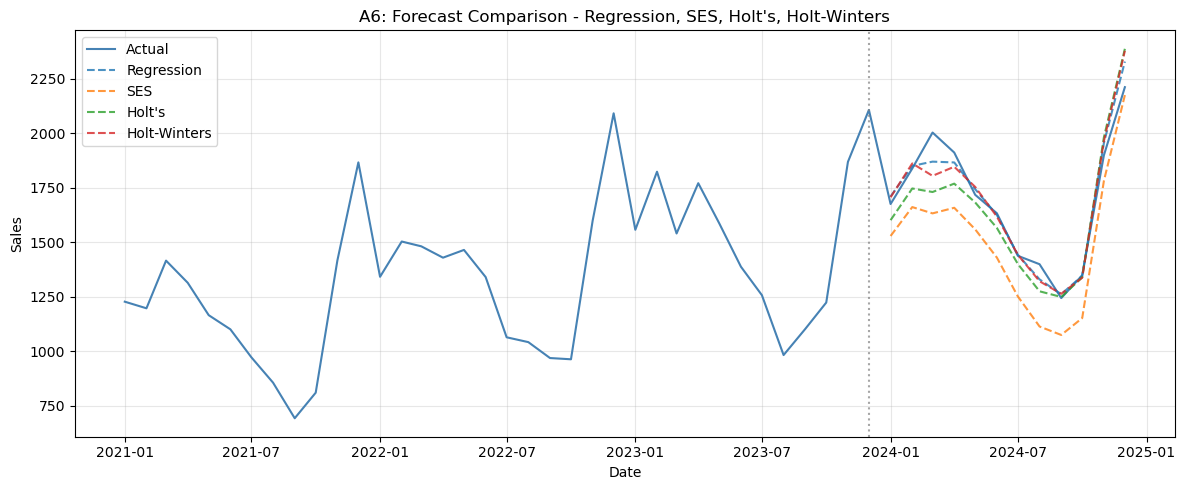

In [16]:
# --------------------------------------------------------------------
# A6: Holt-Winters Seasonal Method
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("A6: Holt-Winters Method")
print("-" * 70)

# 1. Fit Holt-Winters with additive seasonality (first 36 months for training)
hw_train = df_sales['Sales'].iloc[:train_size]
hw_model = ExponentialSmoothing(
    hw_train,
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit(optimized=True)

# 2. Print optimized parameters
alpha_hw = hw_model.params['smoothing_level']
beta_hw = hw_model.params['smoothing_trend']
gamma_hw = hw_model.params['smoothing_seasonal']
print(f"Optimized α (level): {alpha_hw:.4f}")
print(f"Optimized β (trend): {beta_hw:.4f}")
print(f"Optimized γ (seasonal): {gamma_hw:.4f}")

# 3. Extract components (level, trend, seasonal indices)
level_hw = hw_model.level.iloc[-1]
trend_hw = hw_model.trend.iloc[-1]
seasonal_hw = hw_model.season.iloc[-12:]  # Last 12 seasonal indices (one per month)
print(f"\nFinal state:")
print(f"  Level (ℓₜ): {level_hw:.4f}")
print(f"  Trend (bₜ): {trend_hw:.4f}")
print(f"  Seasonal indices (last 12):\n{seasonal_hw}")

# 4. Plot decomposition from Holt-Winters
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
axes[0].plot(hw_train.index, hw_train.values, color='steelblue')
axes[0].set_ylabel('Sales')
axes[0].set_title('Original Series')
axes[0].grid(True, alpha=0.3)

axes[1].plot(hw_train.index, hw_model.level, color='darkgreen')
axes[1].set_ylabel('Level')
axes[1].set_title('Level (ℓₜ)')
axes[1].grid(True, alpha=0.3)

axes[2].plot(hw_train.index, hw_model.trend, color='orange')
axes[2].set_ylabel('Trend')
axes[2].set_title('Trend (bₜ)')
axes[2].grid(True, alpha=0.3)

axes[3].plot(hw_train.index, hw_model.season, color='coral')
axes[3].set_ylabel('Seasonal')
axes[3].set_xlabel('Date')
axes[3].set_title('Seasonal Component')
axes[3].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Generate 12-month forecasts
hw_forecast = hw_model.forecast(steps=holdout_size)

# 6. Compare forecast accuracy with Regression, SES, Holt's method
holdout_actual = df_sales['Sales'].iloc[train_size:train_size + holdout_size].values

def mae(y_true, y_pred):
    return np.mean(np.abs(np.asarray(y_pred) - y_true))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((np.asarray(y_pred) - y_true) ** 2))

# Regression forecast for holdout (need to build X for holdout months)
holdout_dates = df_sales.index[train_size:train_size + holdout_size]
holdout_t = df_reg['Time'].iloc[train_size:train_size + holdout_size].values
holdout_months = holdout_dates.month.values
X_holdout_list = []
for i in range(holdout_size):
    row = {'Time': holdout_t[i]}
    for m in range(1, 12):
        row[f'Month_{m}'] = 1 if holdout_months[i] == m else 0
    X_holdout_list.append(row)
X_holdout = sm.add_constant(pd.DataFrame(X_holdout_list)[['Time'] + [f'Month_{m}' for m in range(1, 12)]])
reg_forecast_holdout = model_reg.predict(X_holdout).values

acc_df = pd.DataFrame({
    'Model': ['Regression', 'SES', "Holt's", 'Holt-Winters'],
    'MAE': [
        mae(holdout_actual, reg_forecast_holdout),
        mae(holdout_actual, ses_forecast),
        mae(holdout_actual, holt_forecast),
        mae(holdout_actual, hw_forecast)
    ],
    'RMSE': [
        rmse(holdout_actual, reg_forecast_holdout),
        rmse(holdout_actual, ses_forecast),
        rmse(holdout_actual, holt_forecast),
        rmse(holdout_actual, hw_forecast)
    ]
})
print("\nForecast accuracy comparison (holdout period):")
print(acc_df.to_string(index=False))

# Plot all forecasts
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df_sales.index, df_sales['Sales'], label='Actual', color='steelblue')
ax.plot(holdout_dates, reg_forecast_holdout, label='Regression', linestyle='--', alpha=0.8)
ax.plot(holdout_dates, ses_forecast, label='SES', linestyle='--', alpha=0.8)
ax.plot(holdout_dates, holt_forecast, label="Holt's", linestyle='--', alpha=0.8)
ax.plot(holdout_dates, hw_forecast, label='Holt-Winters', linestyle='--', alpha=0.8)
ax.axvline(df_sales.index[train_size - 1], color='gray', linestyle=':', alpha=0.7)
ax.set_title("A6: Forecast Comparison - Regression, SES, Holt's, Holt-Winters")
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()